### This notebook is Convolutional neural network implementation for classifying MNIST handwritting with tensorflow.

[MNIST Dataset]  http://yann.lecun.com/exdb/mnist/

[Author] hushenglang@gmail.com

In [12]:
# Import tensoflow lib
import tensorflow as tf

In [13]:
# Check for a GPU
if not tf.test.gpu_device_name():
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

No GPU found. Please use a GPU to train your neural network.


In [14]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data

In [15]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
# define trained model save path
import os
save_model_directory = './Model'
if not os.path.exists(save_model_directory):
    os.makedirs(save_model_directory)

save_model_path = save_model_directory+'/image_classification_tensorflow'

### Build Network

In [6]:
def conv2d(x, filter_height, filter_width, out_channels, stride=1):
    # conv layer wrapper.
    in_channels = x.get_shape()[3].value
    W = tf.Variable(tf.truncated_normal([filter_height, filter_width, in_channels, out_channels], seed=10))
    b = tf.Variable(tf.truncated_normal([out_channels], seed=20))
    conv_x = tf.nn.conv2d(x, W, strides=[1,stride,stride,1], padding="SAME")
    conv_x = tf.nn.bias_add(conv_x, b)
    return tf.nn.relu(conv_x) # here we can also use leaky relu which can prevent dead neron.

In [7]:
def maxpool2d(x, k=2):
    # max pooling wrapper
    return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding="SAME")

In [8]:
def fully_connect(x, num_hidden_units):
    # fully connect wrapper
    num_input = x.get_shape()[1].value;
    W = tf.Variable(tf.truncated_normal([num_input, num_hidden_units], seed=30))
    b = tf.Variable(tf.truncated_normal([num_hidden_units], seed=40))
    logits = tf.matmul(x,W)+b
    return tf.nn.relu(logits)

In [9]:
def output(x, num_output_units):
    # output layer wrapper
    num_input = x.get_shape()[1].value;
    W = tf.Variable(tf.truncated_normal([num_input, num_output_units], seed=50))
    b = tf.Variable(tf.truncated_normal([num_output_units], seed=40))
    logits = tf.matmul(x,W)+b
    return logits

### ConvNet's architecure using here is:
"conv" -> "maxpool" -> "conv" -> "maxpool" ->"full connect"+"dropout" -> "outlayer"

In [10]:
def conv_net(x, dropout, num_hidden_units):
    # build network graph
    x = tf.reshape(x, shape=[-1, 28, 28, 1]) # Reshape input picture
    print(x.shape)
    
    # conv layer 1. filter size: 5x5x32
    conv1 = conv2d(x, 5, 5, 32, stride=1)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    
    # conv layer 2. filter size: 5x5x64
    conv2 = conv2d(conv1, 5, 5, 64, stride=1)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # full connect layer
    fc1 = tf.contrib.layers.flatten(conv2); # later replace this by low-level implementation
    fc1 = fully_connect(fc1, num_hidden_units)
    fc1 = tf.nn.dropout(fc1, dropout) # add dropout
    print(fc1.shape)
    
    # output
    logits = output(fc1, n_class)
    
    print(logits.shape)
    
    return logits

In [11]:
# input param
n_input = 784 # MNIST data input (img shape: 28*28)
n_class = 10 # MNIST total classes (0-9 digits)

# hyper parameter
training_iters = 5*400
batch_size = 128
learning_rate = 0.01
num_hidden_units = 1024
dropout_rate = 0.8 # Dropout, probability to keep units
display_step = 10

In [12]:
# tf graph input
x = tf.placeholder(tf.float32, [None, n_input], name="x")
y = tf.placeholder(tf.float32, [None, n_class], name="y")
keep_prop = tf.placeholder(tf.float32, name="keep_prop")

# define loss and optimizer
logits = conv_net(x, keep_prop, num_hidden_units)
# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# define evaluation accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

# define global initializer
init = tf.global_variables_initializer()

(?, 28, 28, 1)
(?, 14, 14, 32)
(?, 7, 7, 64)
(?, 1024)
(?, 10)


In [14]:
# ready to train model
evaluation_states = {"train_loss": [], "validation_loss": [], "train_accuracy": [], "validation_accuracy": []}
with tf.Session() as sess:
    sess.run(init)
    step = 1
    for i in range(training_iters):
        train_x, train_y = mnist.train.next_batch(batch_size=batch_size)
        sess.run(optimizer, feed_dict={x:train_x, y:train_y, keep_prop:dropout_rate})
        
        if step%display_step == 0: # print train_loss, validation_loss, train_accuracy, validataion_accuracy.
            train_loss_val, train_acc_val = sess.run([loss, accuracy], feed_dict={x:train_x, y:train_y, keep_prop:1.0})
            valid_loss_val, valid_acc_val = sess.run([loss, accuracy], feed_dict={x:mnist.validation.images, y:mnist.validation.labels, keep_prop:1.0})
            print("training step {}/{}: train_loss={:0.4f}, train_accuracy={:0.4f}, validation_accuracy={:0.4f}".format(step, training_iters, train_loss_val, train_acc_val, valid_acc_val))
            evaluation_states["train_loss"].append(train_loss_val)
            evaluation_states["validation_loss"].append(valid_loss_val)
            evaluation_states["train_accuracy"].append(train_acc_val)
            evaluation_states["validation_accuracy"].append(valid_acc_val)
        step += 1
    print ("Optimization Finished!")
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

training step 10/2000: train_loss=12692.4062, train_accuracy=0.4688, validation_accuracy=0.4658
training step 20/2000: train_loss=2331.9766, train_accuracy=0.6172, validation_accuracy=0.7194
training step 30/2000: train_loss=548.4990, train_accuracy=0.8516, validation_accuracy=0.8310
training step 40/2000: train_loss=327.6933, train_accuracy=0.8906, validation_accuracy=0.8598
training step 50/2000: train_loss=529.2123, train_accuracy=0.8125, validation_accuracy=0.8778
training step 60/2000: train_loss=144.4978, train_accuracy=0.8906, validation_accuracy=0.8894
training step 70/2000: train_loss=305.9016, train_accuracy=0.8516, validation_accuracy=0.8982
training step 80/2000: train_loss=82.4152, train_accuracy=0.9453, validation_accuracy=0.9072
training step 90/2000: train_loss=157.2142, train_accuracy=0.8594, validation_accuracy=0.9084
training step 100/2000: train_loss=72.6707, train_accuracy=0.9375, validation_accuracy=0.9132
training step 110/2000: train_loss=56.2719, train_accuracy

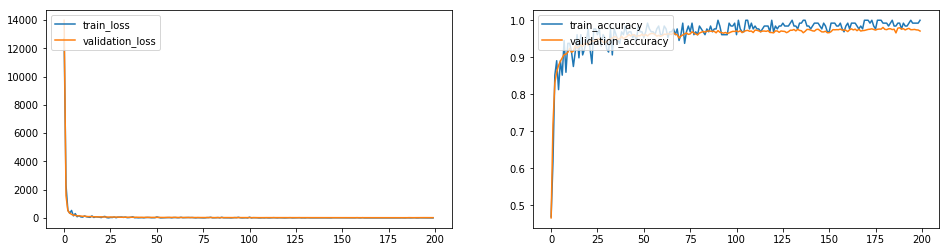

In [15]:
#plot evaluation states
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(121)

ax1.plot(evaluation_states['train_loss'], label="train_loss")
ax1.plot(evaluation_states['validation_loss'], label="validation_loss")
ax1.legend(loc="upper left")

ax2 = fig.add_subplot(122)
ax2.plot(evaluation_states['train_accuracy'], label="train_accuracy")
ax2.plot(evaluation_states['validation_accuracy'], label="validation_accuracy")
ax2.legend(loc="upper left")

In [16]:
# Calculate accuracy mnist test images
loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prop:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    
    test_acc = sess.run(loaded_acc, feed_dict={loaded_x: mnist.test.images,
                                  loaded_y: mnist.test.labels,
                                  loaded_keep_prob: 1.0})

    print ("Testing Accuracy:", test_acc)

Testing Accuracy: 0.969
